# PCA and LDA Projection of Data
[Link to sklearn docs](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#comparison-of-lda-and-pca-2d-projection-of-iris-dataset)

In this worksheet we are going to reduce the number of dimensions of the data using Principle Component Analysis (PCA) and Linear Discriminant Analysis (LDA).  Both methods reduce the data to fewer dimensions by projecting in the directions of greatest variance.  LDA also takes the class into account in order to maximize differences between classes in the projected data.

We will include the standardization step from the previous stage.

In [2]:
# get the data and resample
import ml_utils as mu

# get the training data
data = mu.get_training_data()
X, y = mu.split_x_and_y(data)

# get the holdout and outside validation data
Xh, yh = mu.split_x_and_y(mu.get_holdout_data())
Xh, yh = mu.resample_to_equal_class_sizes(Xh, yh)

Xv, yv = mu.split_x_and_y(mu.get_validation_data())
Xv, yv = mu.resample_to_equal_class_sizes(Xv, yv)

Maximum class size is 80
Class 0 size is 48. Resampling with replacement to 80
Class 1 size has max class size (80).
Class 2 size is 11. Resampling with replacement to 80
Class 3 size is 11. Resampling with replacement to 80
Maximum class size is 32
Class 0 size is 6. Resampling with replacement to 32
Class 1 size has max class size (32).
Class 2 size is 4. Resampling with replacement to 32
Class 3 size is 8. Resampling with replacement to 32


In [3]:
target_names = ['Control', 'Parkinsons', 'MSA', 'PSP']


## Principal Component Analysis
Will find the best **n** number of components to use

[2018-06-30 15:43:42.662389] Starting knn
[2018-06-30 15:43:46.440683] Done with knn (Took 0.063 minutes minutes)
[2018-06-30 15:43:46.473687] Starting svc_lin
[2018-06-30 15:43:53.588583] Done with svc_lin (Took 0.119 minutes minutes)
[2018-06-30 15:43:53.621084] Starting svc_rbf
[2018-06-30 15:44:07.783168] Done with svc_rbf (Took 0.236 minutes minutes)
[2018-06-30 15:44:07.816670] Starting rand_for
[2018-06-30 15:44:14.190976] Done with rand_for (Took 0.106 minutes minutes)
[2018-06-30 15:44:14.231991] Starting ada
[2018-06-30 15:44:47.747946] Done with ada (Took 0.559 minutes minutes)
[2018-06-30 15:44:47.783448] Starting gnb
[2018-06-30 15:44:49.799450] Done with gnb (Took 0.034 minutes minutes)
[2018-06-30 15:44:49.833450] Starting log
[2018-06-30 15:44:56.919306] Done with log (Took 0.118 minutes minutes)
[2018-06-30 15:44:56.953322] Starting ann
[2018-06-30 15:46:39.836484] Done with ann (Took 1.715 minutes minutes)


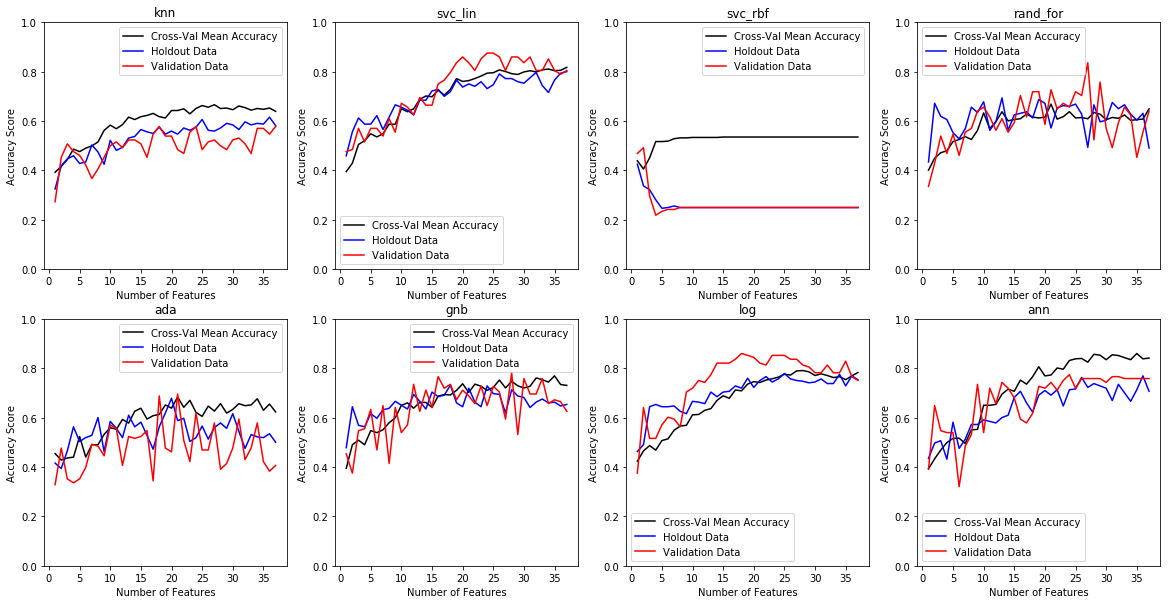

,mean_cv_acc,bestN,mean_bestN_cv_acc,holdout_bestN_acc,valid_bestN_acc
knn,0.646,26,0.666,0.559,0.523
svc_lin,0.819,36,0.817,0.800,0.805
svc_rbf,0.535,14,0.535,0.250,0.250
rand_for,0.819,20,0.668,0.572,0.727
ada,0.583,20,0.683,0.588,0.695
gnb,0.760,34,0.769,0.662,0.672
log,0.774,27,0.790,0.747,0.812
ann,0.853,34,0.859,0.713,0.758


In [13]:
import sys, os
import datetime
import time

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

from matplotlib import pyplot as plt
from IPython.display import display

classifiers = mu.get_baseline_models()
df = pd.DataFrame(columns=['mean_cv_acc', 'bestN', 'mean_bestN_cv_acc', 'holdout_bestN_acc', 'valid_bestN_acc'], index=[clf['name'] for clf in classifiers])
fig = plt.figure(figsize=(20,10))

for index, clf in enumerate(classifiers):
    model = clf['model']
    name = clf['name']
    
    start = time.time()
    print("[%s] Starting %s" %(datetime.datetime.now(), name))

    # Run through all possible number of features and save the classifier, test data score and validation data scores
    cross_val_scores = []
    holdout_data_scores = []
    valid_data_scores = []

    # Without PCA
    pipeline = Pipeline([
        ('standardize', StandardScaler()),
        ('oversample', RandomOverSampler()),
        ('classifier', model)
    ])

    cross_val_acc = cross_val_score(pipeline, X, y, cv=StratifiedKFold(5)).mean()
    df.loc[name]['mean_cv_acc'] = cross_val_acc 
    
    ns = range(1, min(X.shape)+1)
    for n in ns:
        sys.stdout.write("\rStarting PCA with %d features (of %d)" %(n, min(X.shape)))
        sys.stdout.flush()
        
        # With PCA
        pipelinePCA = Pipeline([
            ('standardize', StandardScaler()),
            ('oversample', RandomOverSampler()),
            ('pca', PCA(n_components=n)),
            ('classifier', model)
        ])
        
        cross_val_acc = cross_val_score(pipelinePCA, X, y, cv=StratifiedKFold(5)).mean()
        
        #train a model with all of the X data
        pipelinePCA.fit(X,y)
        
        cross_val_scores.append(cross_val_acc)
        holdout_data_scores.append(pipelinePCA.score(Xh,yh))
        valid_data_scores.append(pipelinePCA.score(Xv, yv))
    
    end = time.time()
    time_elapsed = "%.3f minutes" %((end-start)/60)
    sys.stdout.write("\r[%s] Done with %s (Took %s minutes)" %(datetime.datetime.now(),name, time_elapsed))
    sys.stdout.flush()
    print()
    
    # Figure out which N yielded the highest mean cross-validation accuracy
    bestN = np.argmax(cross_val_scores)
    
    # Store the 
    df.loc[name]['bestN'] = bestN+1
    df.loc[name]['mean_bestN_cv_acc'] = cross_val_scores[bestN]
    df.loc[name]['holdout_bestN_acc'] = holdout_data_scores[bestN]
    df.loc[name]['valid_bestN_acc'] = valid_data_scores[bestN]

    plt.subplot(2, 4,index+1)
    plt.plot(ns, cross_val_scores, color='black', label='Cross-Val Mean Accuracy')
    plt.plot(ns, holdout_data_scores, color='blue', label='Holdout Data')
    plt.plot(ns, valid_data_scores, color='red', label='Validation Data')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy Score')
    plt.ylim([0,1])
    plt.title(name)
    plt.legend()
    
plt.show()
fig.savefig('images/pca_ns.png')
df1 = df.copy()
display(df1)

It appears that PCA will not help us much here.  Accuracy is more or less monotonic increasing with number of components and therefore our best model is going to use all of the data.

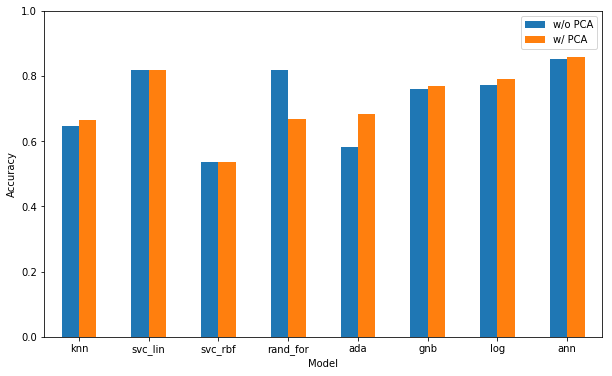

In [15]:
%matplotlib inline
ax = df1.drop(['bestN', 'holdout_bestN_acc', 'valid_bestN_acc'], axis=1).plot(kind='bar', figsize=(10,6), rot=0)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ybound((0,1))
l = ax.legend(labels=['w/o PCA', 'w/ PCA'])
fig = ax.get_figure()
fig.savefig('images/pca_acc.png')

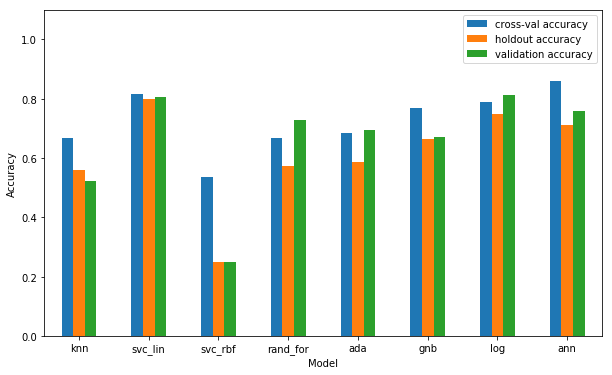

In [16]:
%matplotlib inline
ax = df1.drop(['mean_cv_acc', 'bestN'], axis=1).plot(kind='bar', figsize=(10,6), rot=0)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ybound((0,1.1))
l = ax.legend(labels=['cross-val accuracy','holdout accuracy', 'validation accuracy'])
fig = ax.get_figure()
fig.savefig('images/pca_validation_fscore.png')

### Linear Discriminant Anaylsis
LDA always projects the data to `[number of classes] - 1` components or less. We will find which n yields the best results

[2018-06-30 16:10:49.483433] Starting knn
[2018-06-30 16:10:49.729940] Done with knn (Took 0.004 minutes minutes)
[2018-06-30 16:10:49.764442] Starting svc_lin
[2018-06-30 16:10:50.240717] Done with svc_lin (Took 0.008 minutes minutes)
[2018-06-30 16:10:50.277723] Starting svc_rbf
[2018-06-30 16:10:51.165905] Done with svc_rbf (Took 0.015 minutes minutes)
[2018-06-30 16:10:51.198914] Starting rand_for
[2018-06-30 16:10:51.741001] Done with rand_for (Took 0.009 minutes minutes)
[2018-06-30 16:10:51.775508] Starting ada
[2018-06-30 16:10:54.190020] Done with ada (Took 0.040 minutes minutes)
[2018-06-30 16:10:54.220311] Starting gnb
[2018-06-30 16:10:54.391998] Done with gnb (Took 0.003 minutes minutes)
[2018-06-30 16:10:54.423001] Starting log
[2018-06-30 16:10:55.162929] Done with log (Took 0.012 minutes minutes)
[2018-06-30 16:10:55.197440] Starting ann
[2018-06-30 16:11:04.708216] Done with ann (Took 0.159 minutes minutes)


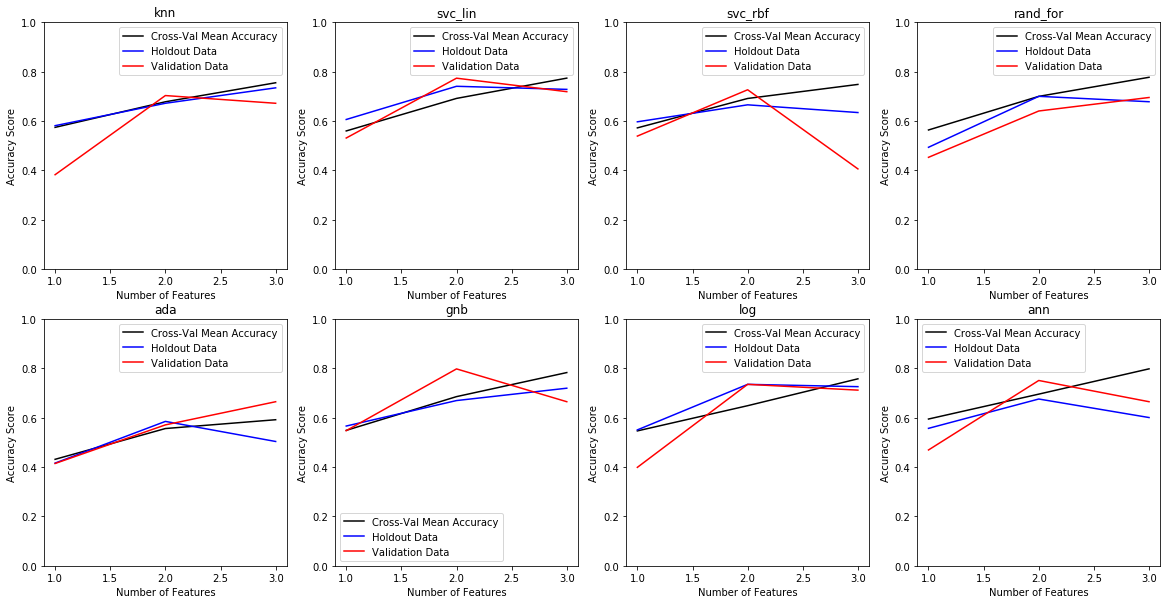

,mean_cv_acc,bestN,mean_bestN_cv_acc,holdout_bestN_acc,valid_bestN_acc
knn,0.635938,3,0.754918,0.734375,0.671875
svc_lin,0.803792,3,0.773662,0.728125,0.71875
svc_rbf,0.53527,3,0.748193,0.634375,0.40625
rand_for,0.824159,3,0.777096,0.678125,0.695312
ada,0.567814,3,0.591166,0.503125,0.664062
gnb,0.756809,3,0.782023,0.71875,0.664062
log,0.7753,3,0.756753,0.725,0.710938
ann,0.839162,3,0.797123,0.6,0.664062


In [8]:
import sys, os
import datetime
import time

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

from matplotlib import pyplot as plt
from IPython.display import display

classifiers = mu.get_baseline_models()
df = pd.DataFrame(columns=['mean_cv_acc', 'bestN', 'mean_bestN_cv_acc', 'holdout_bestN_acc', 'valid_bestN_acc'], index=[clf['name'] for clf in classifiers])
fig = plt.figure(figsize=(20,10))

for index, clf in enumerate(classifiers):
    model = clf['model']
    name = clf['name']
    
    start = time.time()
    print("[%s] Starting %s" %(datetime.datetime.now(), name))

    # Run through all possible number of features and save the classifier, test data score and validation data scores
    cross_val_scores = []
    holdout_data_scores = []
    valid_data_scores = []

    # Without LDA
    pipeline = Pipeline([
        ('standardize', StandardScaler()),
        ('oversample', RandomOverSampler()),
        ('classifier', model)
    ])

    cross_val_acc = cross_val_score(pipeline, X, y, cv=StratifiedKFold(5)).mean()
    df.loc[name]['mean_cv_acc'] = cross_val_acc 
    
    ns = range(1, len(y.value_counts()))
    for n in ns:
        sys.stdout.write("\rStarting LDA with %d features (of %d)" %(n, min(X.shape)))
        sys.stdout.flush()
        
        # With LDA
        pipelineLDA = Pipeline([
            ('standardize', StandardScaler()),
            ('oversample', RandomOverSampler()),
            ('lda', LinearDiscriminantAnalysis(n_components=n)),
            ('classifier', model)
        ])
        
        cross_val_acc = cross_val_score(pipelineLDA, X, y, cv=StratifiedKFold(5)).mean()
        
        #train a model with all of the X data
        pipelineLDA.fit(X,y)
        
        cross_val_scores.append(cross_val_acc)
        holdout_data_scores.append(pipelineLDA.score(Xh,yh))
        valid_data_scores.append(pipelineLDA.score(Xv, yv))
    
    end = time.time()
    time_elapsed = "%.3f minutes" %((end-start)/60)
    sys.stdout.write("\r[%s] Done with %s (Took %s minutes)" %(datetime.datetime.now(),name, time_elapsed))
    sys.stdout.flush()
    print()
    
    # Figure out which N yielded the highest mean cross-validation accuracy
    bestN = np.argmax(cross_val_scores)
    
    # Store the 
    df.loc[name]['bestN'] = bestN+1
    df.loc[name]['mean_bestN_cv_acc'] = cross_val_scores[bestN]
    df.loc[name]['holdout_bestN_acc'] = holdout_data_scores[bestN]
    df.loc[name]['valid_bestN_acc'] = valid_data_scores[bestN]

    plt.subplot(2, 4,index+1)
    plt.plot(ns, cross_val_scores, color='black', label='Cross-Val Mean Accuracy')
    plt.plot(ns, holdout_data_scores, color='blue', label='Holdout Data')
    plt.plot(ns, valid_data_scores, color='red', label='Validation Data')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy Score')
    plt.ylim([0,1])
    plt.title(name)
    plt.legend()
    
plt.show()
fig.savefig('images/lda_ns.png')
df1 = df.copy()
display(df1)

Nothing surprising here.  We should use all 3 components yielded from LDA

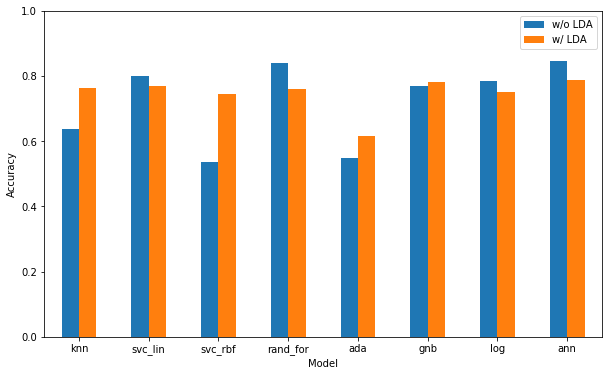

In [5]:
%matplotlib inline
ax = df1.drop(['bestN', 'holdout_bestN_acc', 'valid_bestN_acc'], axis=1).plot(kind='bar', figsize=(10,6), rot=0)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ybound((0,1))
l = ax.legend(labels=['w/o LDA', 'w/ LDA'])
fig = ax.get_figure()
fig.savefig('images/lda_acc.png')

We see major gaines for a few of the models, namely knn, svc_rbfm and ada.  But knn and rbf are also poorly performant on the Validation data.

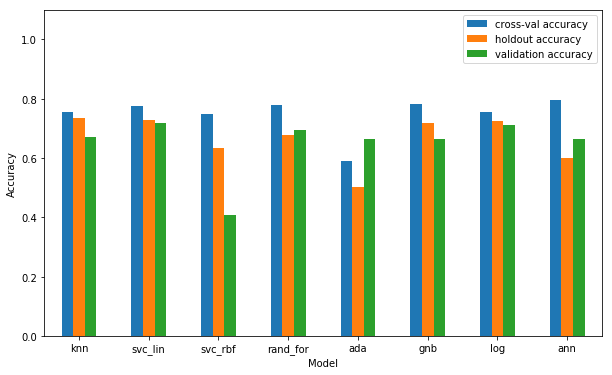

In [18]:
%matplotlib inline
ax = df1.drop(['mean_cv_acc', 'bestN'], axis=1).plot(kind='bar', figsize=(10,6), rot=0)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_ybound((0,1.1))
l = ax.legend(labels=['cross-val accuracy','holdout accuracy', 'validation accuracy'])
fig = ax.get_figure()
fig.savefig('images/lda_validation.png')

### Visualizing the LDA projected data
Since LDA projects the data to 3 dimensions, we can now visualize the data in a 3d plot.

In [12]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

pipelineLDA = Pipeline([
    ('standardize', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis(n_components=n))
])

#train a model with all of the X data
X_lda = pipelineLDA.fit_transform(X,y)

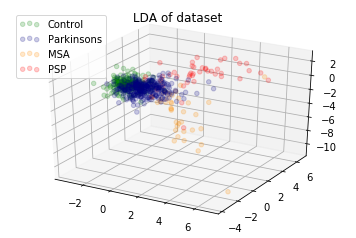

In [17]:
%matplotlib inline
# Plot the LDA-transformed training data in 3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['green', 'navy', 'darkorange', 'red']
target_names = ['Control', 'Parkinsons', 'MSA', 'PSP']
for color, i, target_name in zip(colors, [0, 1, 2, 3], target_names):
    ax.scatter(X_lda[y == i, 0], X_lda[y == i, 1], X_lda[y == i, 2], alpha=.2, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title('LDA of dataset')

plt.show()